<a href="https://colab.research.google.com/github/JoseHelioF/RedeGAN/blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from IPython import display


In [121]:
imgsize = 28
batch_size = 128
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/GAN'
IMG_DIR = os.path.join(DATA_DIR, 'results')

In [122]:
fashiotransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
fashiondata = datasets.FashionMNIST(DATA_DIR,transform = fashiotransform, download=True)
dataloader = DataLoader(fashiondata, batch_size=batch_size, shuffle=True)

In [123]:
img, label = fashiondata[0]


In [124]:
def lookat_dataset(dataset, piling=False):
    figure = plt.figure(figsize=(16, 4))
    cols, rows = 2, 8
    for i in range(1, 17):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]

        figure.add_subplot(rows, cols, i)
        plt.axis("off")

        if piling:
            if img.shape[0] == 1:
                img = img.squeeze()
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img.permute(1, 2, 0))
        else:
            # Convertendo imagem para valores entre 0 e 1
            img = (img.squeeze() * 0.5) + 0.5

            if len(img.shape) == 2:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img.permute(1, 2, 0))

    plt.show()

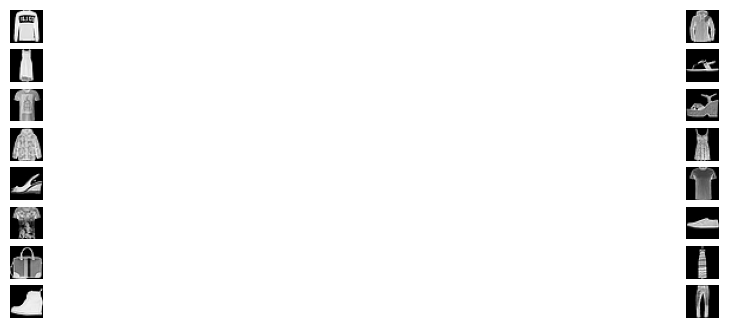

In [125]:
lookat_dataset(fashiondata, True)

In [126]:
class Generator(nn.Module):
    def __init__(self,n_in,n_out):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(n_in, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_out),
            nn.Tanh()
            )
    def forward(self,z):
      return self.layers(z)

class Discriminator(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        n_out = 1

        self.layers = nn.Sequential(
            nn.Linear(n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [128]:
noise_dim = 100
generator = Generator(noise_dim, imgsize**2)
discriminator = Discriminator(imgsize**2)

In [129]:
def images_to_vectors(images):
  return images.view(images.size(0), imgsize**2)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, imgsize, imgsize)

def noise(size,dim = noise_dim,device = device):
  return torch.randn(size,dim).to(device)

#Visualização
def log_images(test_images,savepath = None):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace=-0.08, hspace=0.01)
  cols, rows = len(test_images)//4,4
  for i,img in enumerate(test_images):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap = "gray")
  if savepath is not None:
    figure.savefig(savepath)
  plt.show()

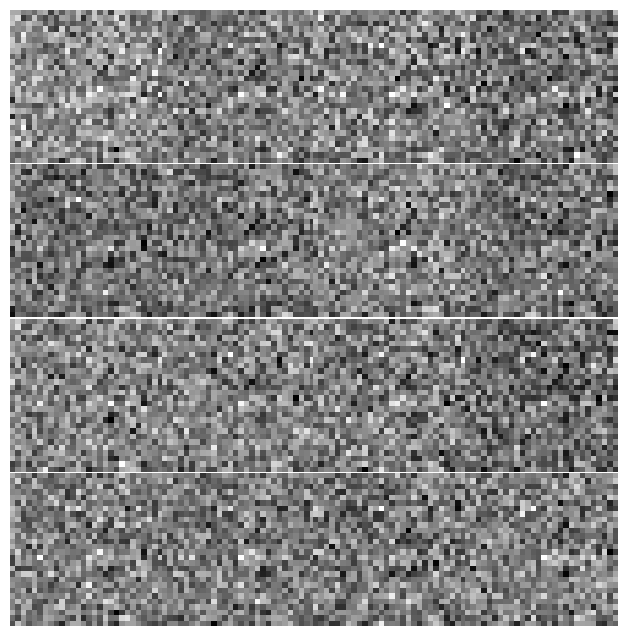

In [130]:
num_test_samples = 16
torch.manual_seed(7777)
test_noise = noise(num_test_samples, noise_dim)
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')
log_images(vectors_to_images(generator(test_noise)).cpu().detach().numpy(),imagepath)


In [131]:
def real_data_target(size, device = device):
  return torch.ones(size,1).to(device)

def fake_data_target(size, device = device):
  return torch.zeros(size,1).to(device)

In [132]:
lr=0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
loss_function = nn.BCELoss()

In [133]:
def train_discriminator(optimizer,real_data,fake_data):
  optimizer.zero_grad()

  pred_real = discriminator(real_data)
#Só a parte referente ao dado real
  error_real = loss_function(pred_real,real_data_target(real_data.size(0)))
  error_real.backward()

  pred_fake = discriminator(fake_data)
  error_fake = loss_function(pred_fake,fake_data_target(fake_data.size(0)))
  error_fake.backward()

  optimizer.step()

  return error_real + error_fake, pred_real, pred_fake

def train_generator(optimizer,fake_data):
  optimizer.zero_grad()

  pred = discriminator(fake_data)
  error = loss_function(pred,real_data_target(pred.size(0)))
  error.backward()
  optimizer.step()

  return error

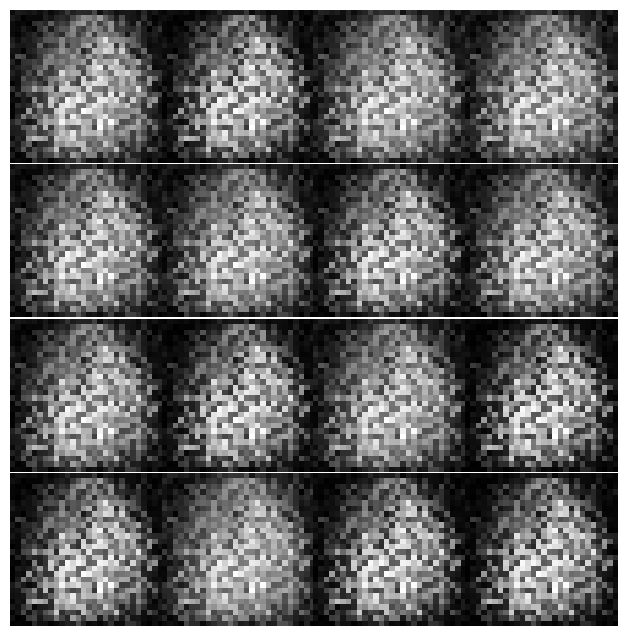

Epoch 0/20 Losses:
D_loss: 0.2998, G_loss: 8.2624
D(x): 0.9694, D(G(z)): 0.1204


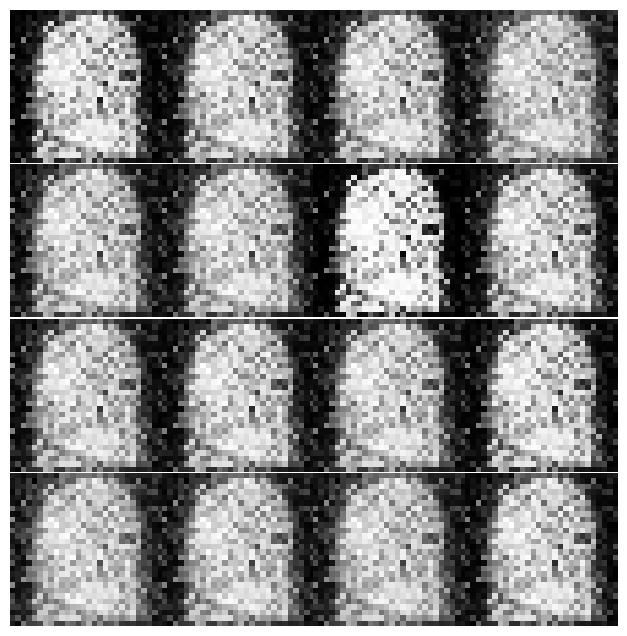

Epoch 1/20 Losses:
D_loss: 0.0931, G_loss: 5.8322
D(x): 0.9676, D(G(z)): 0.0356


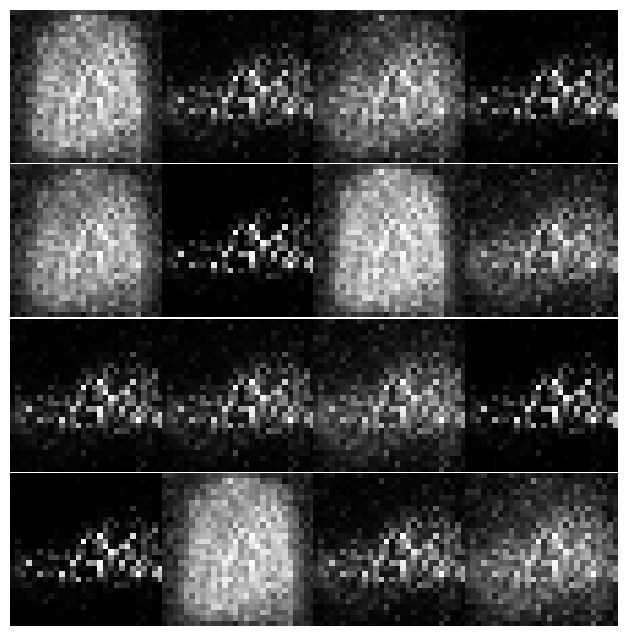

Epoch 2/20 Losses:
D_loss: 0.0738, G_loss: 5.3473
D(x): 0.9747, D(G(z)): 0.0196


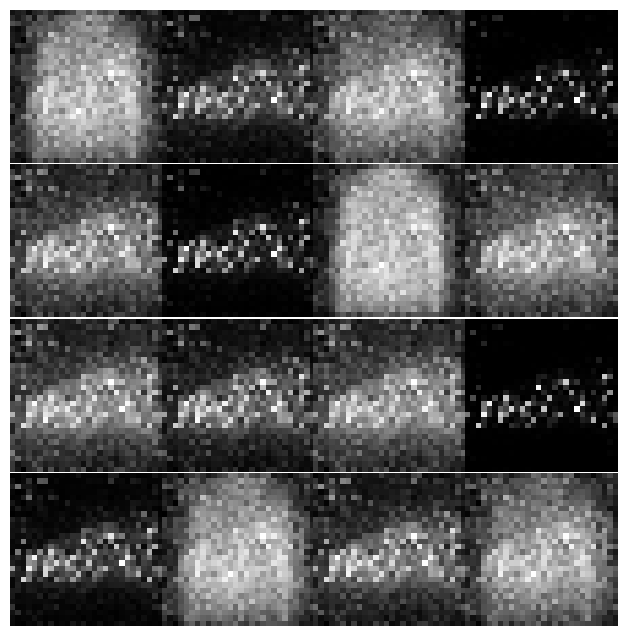

Epoch 3/20 Losses:
D_loss: 0.4588, G_loss: 5.3842
D(x): 0.9183, D(G(z)): 0.0252


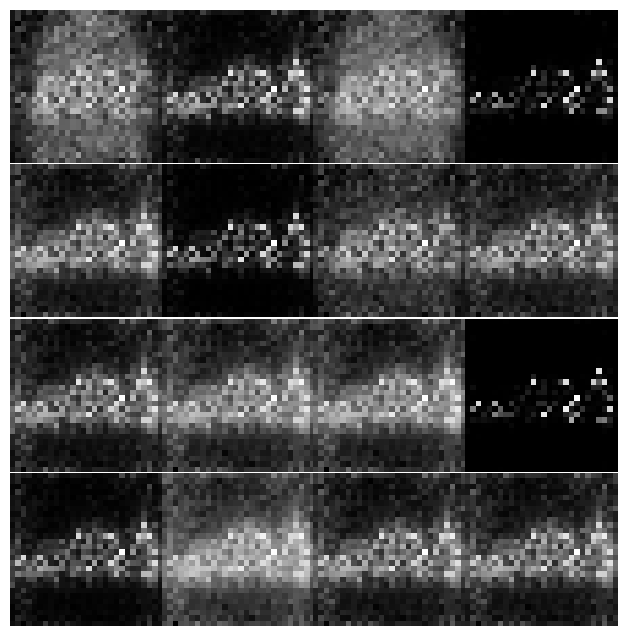

Epoch 4/20 Losses:
D_loss: 0.2625, G_loss: 4.8217
D(x): 0.9322, D(G(z)): 0.0316


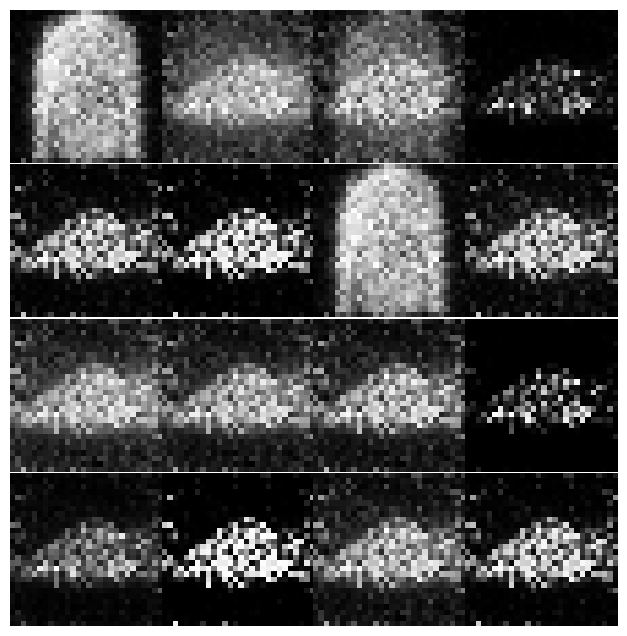

Epoch 5/20 Losses:
D_loss: 0.0754, G_loss: 6.0855
D(x): 0.9708, D(G(z)): 0.0190


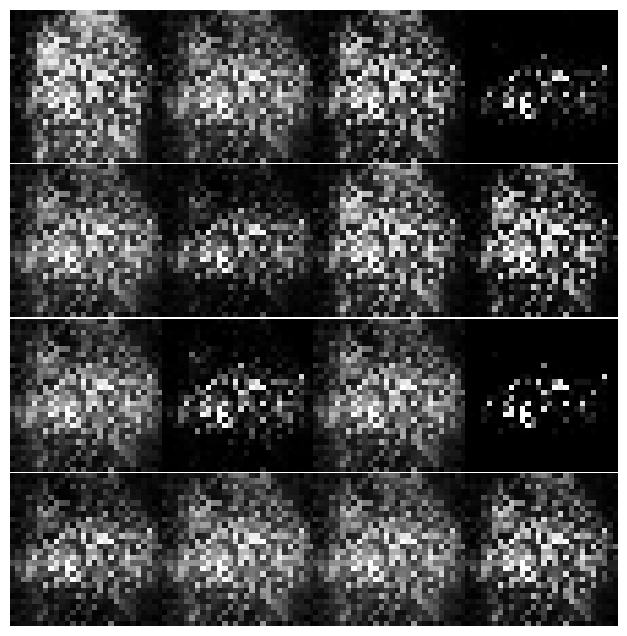

Epoch 6/20 Losses:
D_loss: 0.0558, G_loss: 5.8441
D(x): 0.9892, D(G(z)): 0.0283


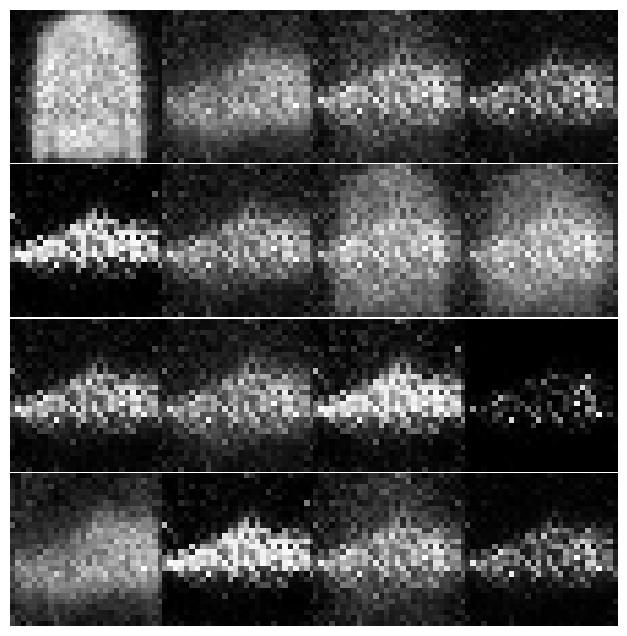

Epoch 7/20 Losses:
D_loss: 0.2816, G_loss: 3.5615
D(x): 0.9221, D(G(z)): 0.0890


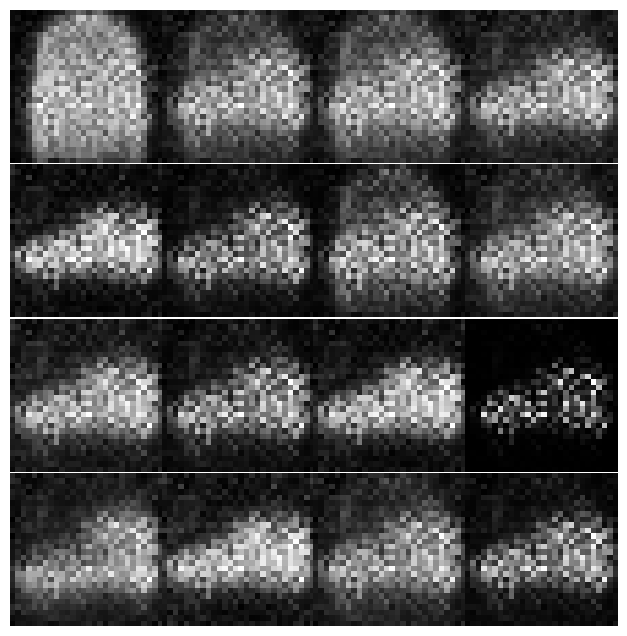

Epoch 8/20 Losses:
D_loss: 0.1926, G_loss: 2.9125
D(x): 0.9485, D(G(z)): 0.0770


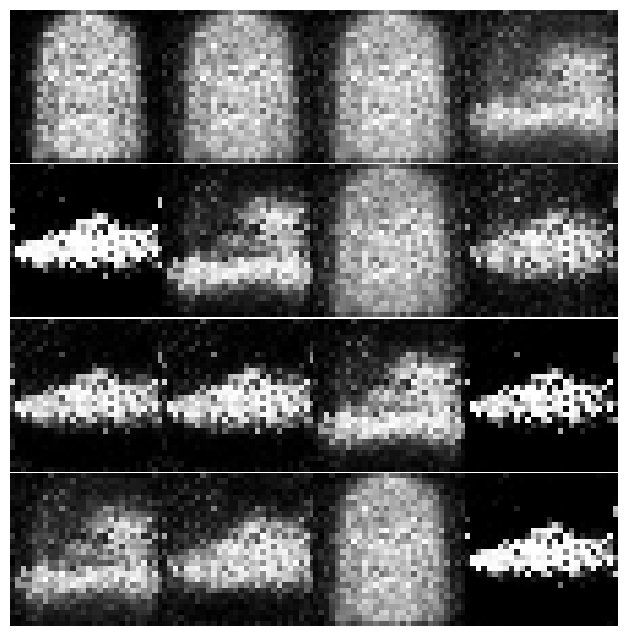

Epoch 9/20 Losses:
D_loss: 0.1825, G_loss: 3.2874
D(x): 0.9660, D(G(z)): 0.1021


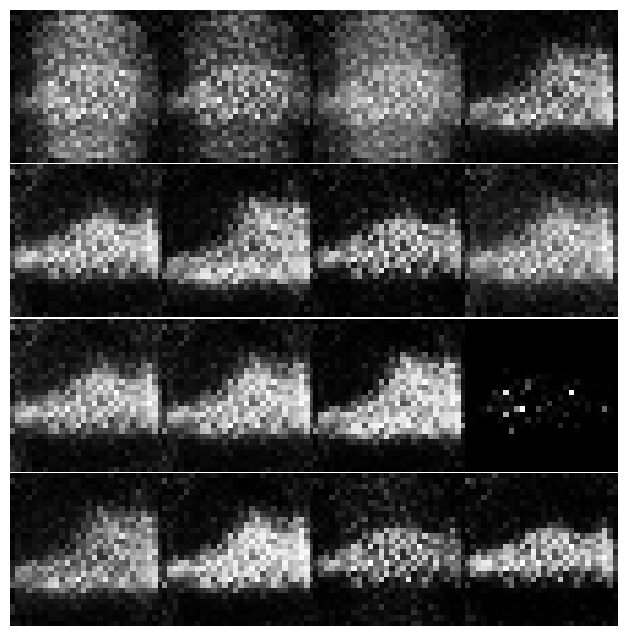

Epoch 10/20 Losses:
D_loss: 0.1162, G_loss: 3.8756
D(x): 0.9677, D(G(z)): 0.0380


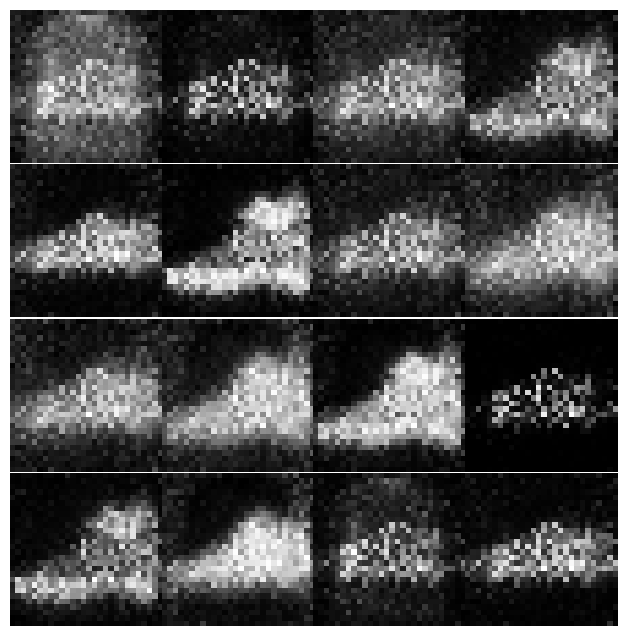

Epoch 11/20 Losses:
D_loss: 0.3158, G_loss: 4.1337
D(x): 0.9305, D(G(z)): 0.0228


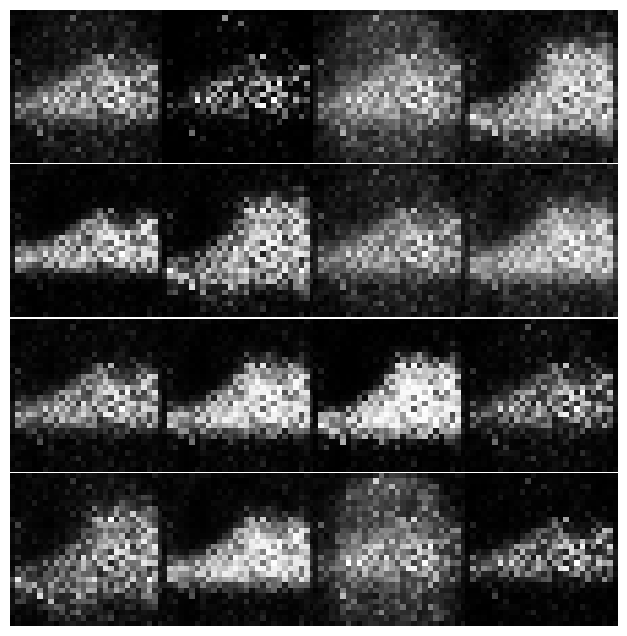

Epoch 12/20 Losses:
D_loss: 0.2239, G_loss: 3.0832
D(x): 0.9683, D(G(z)): 0.1136


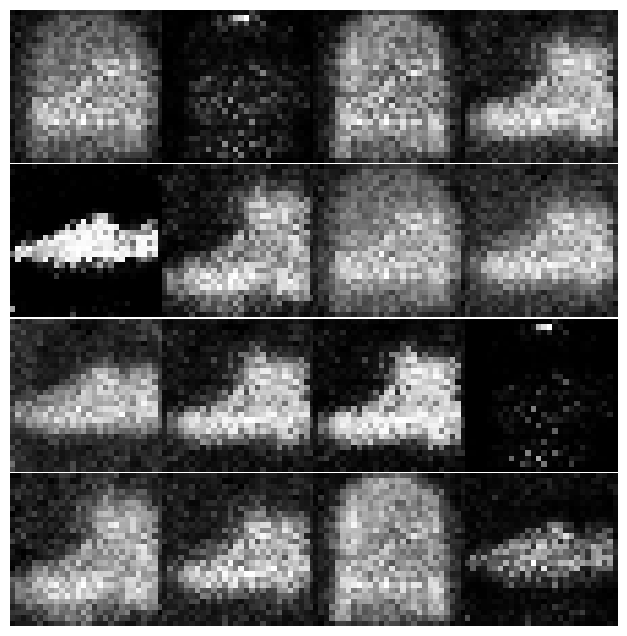

Epoch 13/20 Losses:
D_loss: 0.3973, G_loss: 2.8749
D(x): 0.9012, D(G(z)): 0.1236


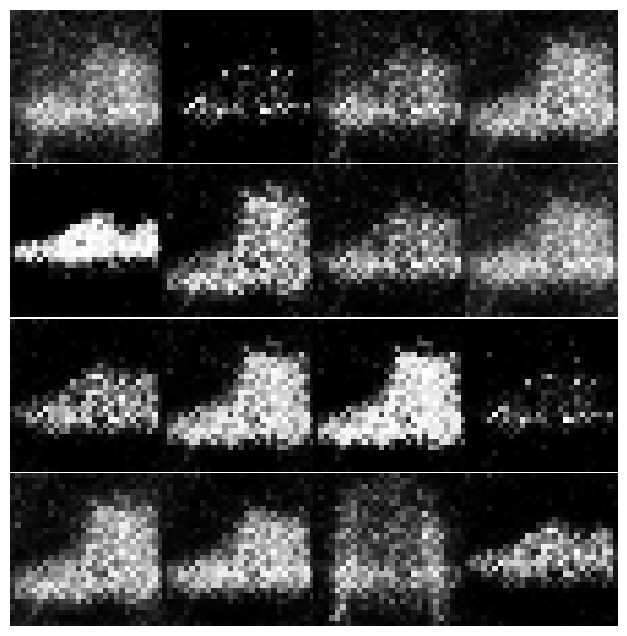

Epoch 14/20 Losses:
D_loss: 0.4174, G_loss: 5.6485
D(x): 0.8634, D(G(z)): 0.0076


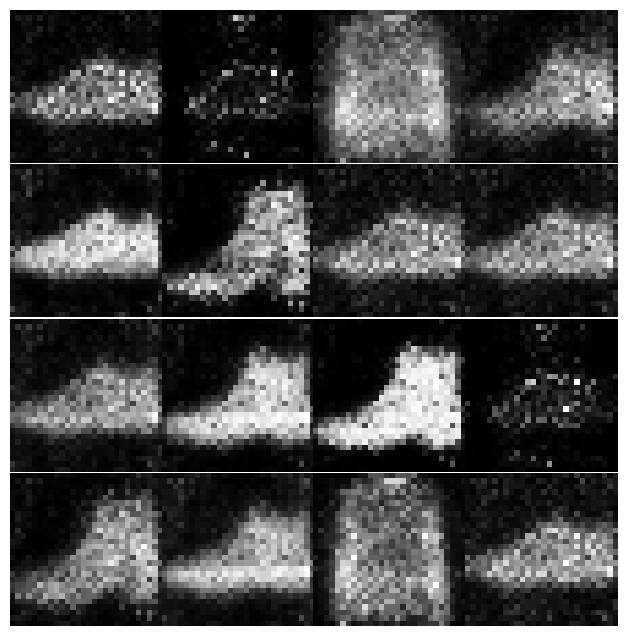

Epoch 15/20 Losses:
D_loss: 0.3884, G_loss: 4.0848
D(x): 0.9046, D(G(z)): 0.1037


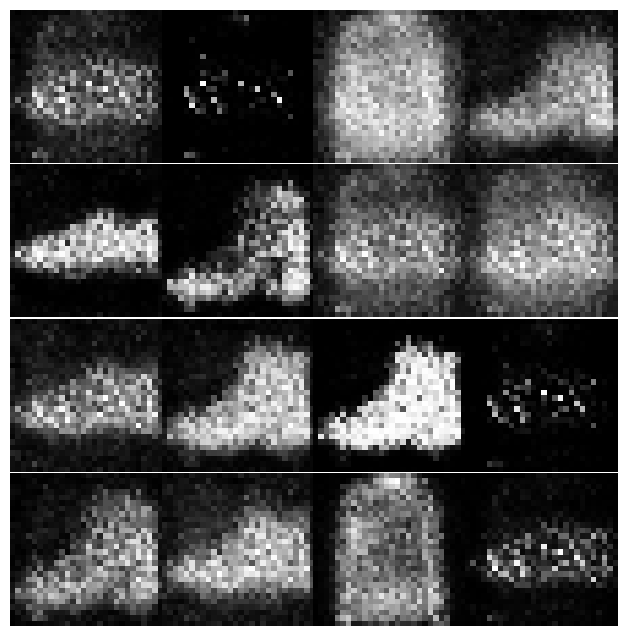

Epoch 16/20 Losses:
D_loss: 0.3081, G_loss: 3.1855
D(x): 0.9445, D(G(z)): 0.1565


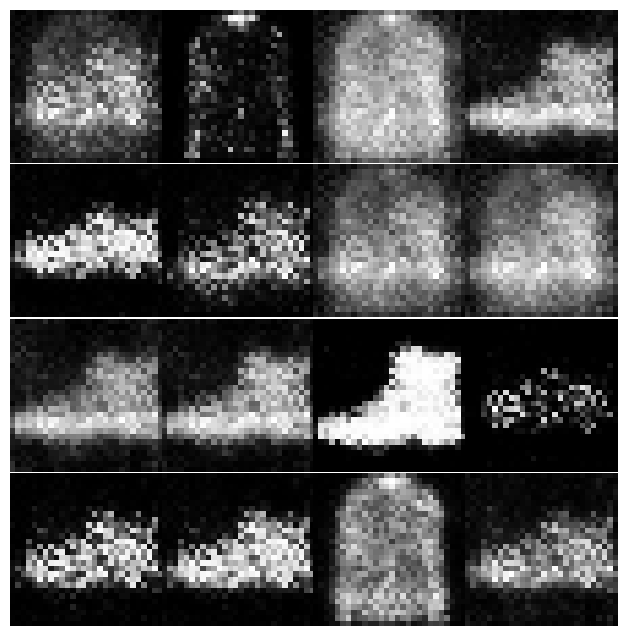

Epoch 17/20 Losses:
D_loss: 0.2929, G_loss: 4.2864
D(x): 0.9167, D(G(z)): 0.1283


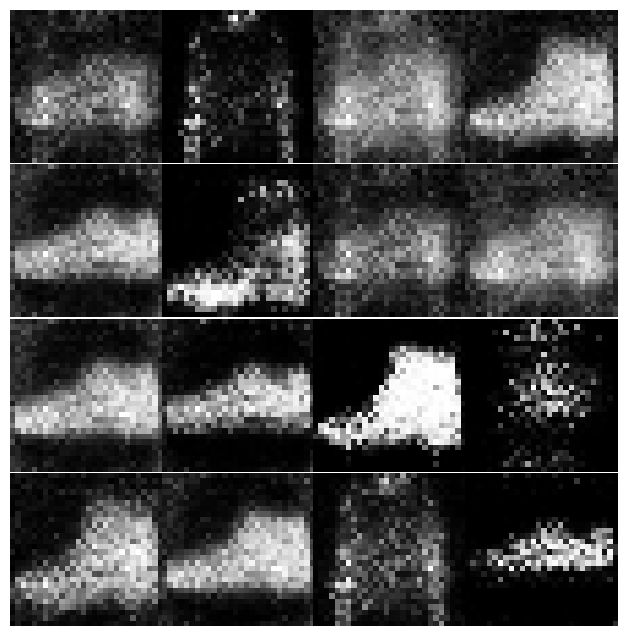

Epoch 18/20 Losses:
D_loss: 0.2090, G_loss: 3.2286
D(x): 0.9624, D(G(z)): 0.1355


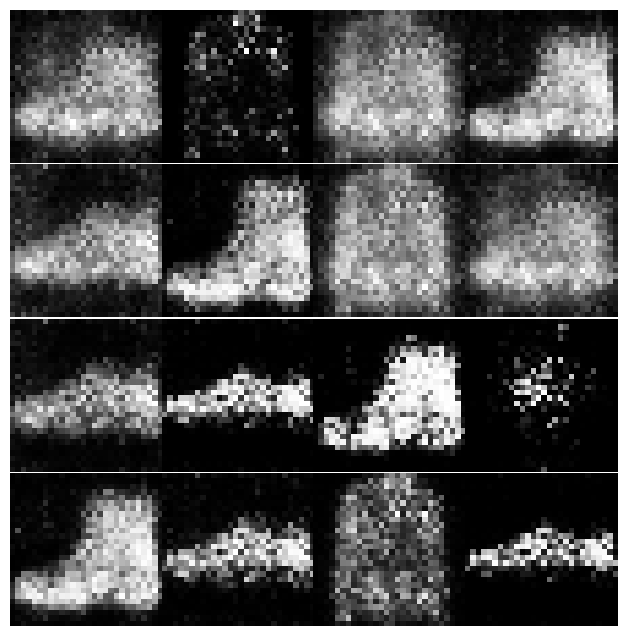

Epoch 19/20 Losses:
D_loss: 0.4420, G_loss: 2.6920
D(x): 0.8569, D(G(z)): 0.1305


In [135]:
num_epochs = 20
G_losses,D_losses = [],[]
for epoch in range(num_epochs):
  for real_batch, _ in dataloader:
    real_data = images_to_vectors(real_batch).to(device)
    fake_data = generator(noise(real_data.size(0)))
    d_error, dpred_real, dpred_fake = train_discriminator(d_optimizer,real_data,fake_data)

    fake_data = generator(noise(real_batch.size(0)))
    g_error = train_generator(g_optimizer,fake_data)

  #show generate image
  imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
  test_images = vectors_to_images(generator(test_noise)).cpu().detach().numpy()
  log_images(test_images,imagepath)

  #Display status log
  G_losses.append(g_error)
  D_losses.append(d_error)
  print(f"Epoch {epoch}/{num_epochs} Losses:")
  print(f"D_loss: {d_error:.4f}, G_loss: {g_error:.4f}")
  print(f"D(x): {dpred_real.mean():.4f}, D(G(z)): {dpred_fake.mean():.4f}")



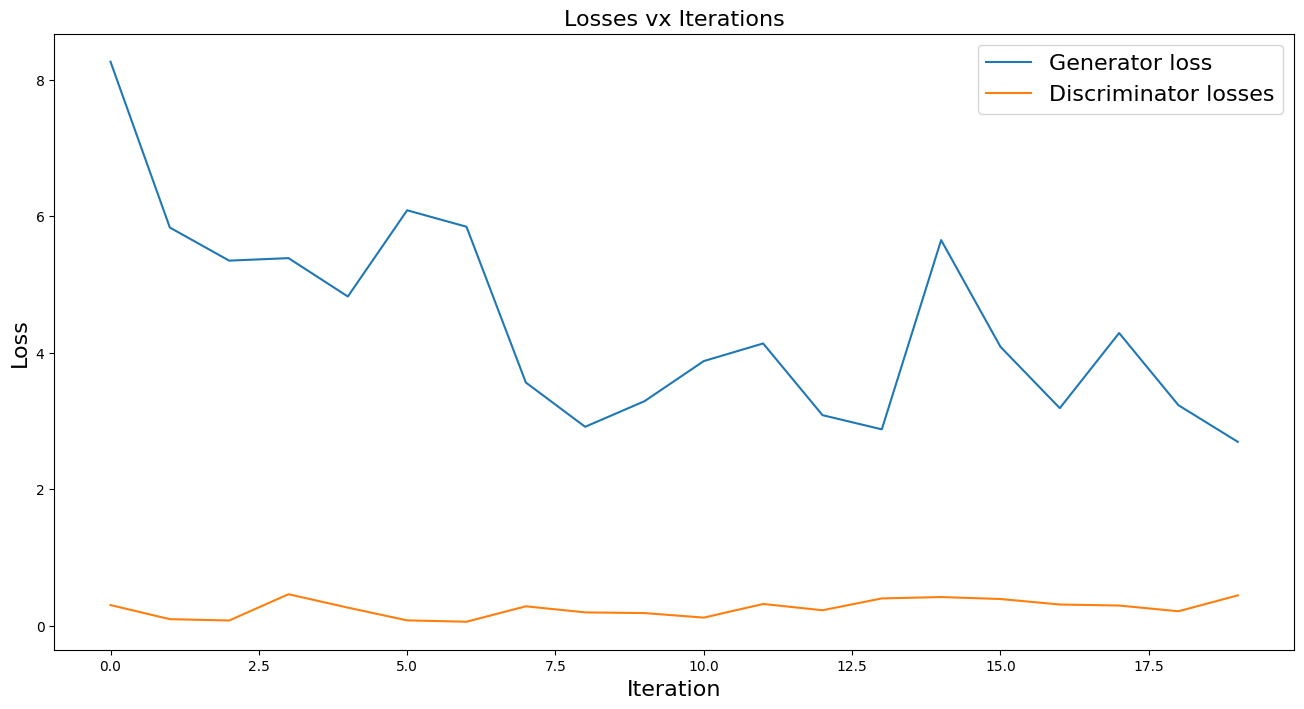

In [137]:
def plot_losses(losses):
  fig = plt.figure(figsize=(16,8))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    loss_values = [k.item() for k in loss_values]
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize = "16")
  ax.set_xlabel('Iteration',fontsize = "16")
  ax.set_ylabel('Loss',fontsize = "16")
  ax.set_title('Losses vx Iterations',fontsize = "16")

plot_losses({"Generator loss":G_losses, "Discriminator losses":D_losses})